In [55]:
import numpy as np
import scipy.signal as sig
import matplotlib.pyplot as plt
import pandas as pd

from pycbc.types import TimeSeries
from pycbc.filter.qtransform import qseries

In [2]:
import jax
import jax.numpy as jnp

In [3]:
from functools import partial

import antiglitch
from antiglitch import rfft, irfft
from antiglitch import center
from antiglitch import downsample_invasd

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [4]:
ml_key = {'tomte': 'Tomte', 'blip' : 'Blip', 'koi' : 'Koi_Fish', 'lowblip': 'Blip_Low_Frequency'}

In [5]:
def upsample_invasd(invasd, tlen):
    """Reduce frequency resolution of the inverse ASD to a given number of time samples"""
    workspace = np.zeros(tlen, dtype=invasd.dtype)
    td = irfft(invasd)
    workspace[:len(td)] = sig.hann(len(td))*np.roll(td, len(td)//2)
    tmp = np.abs(rfft(workspace))
    tmp[0] = 0.
    return tmp

In [6]:
freqs = jnp.linspace(0, 4096, 513)
freqs2 = jnp.linspace(0, 4096, 1+4*4096)

@jax.jit
def fsignal(freqs, f0, gbw):
    return jnp.exp(-0.5*gbw*(jnp.log(freqs) - jnp.log(f0))**2)

def fglitch_normed(freqs, invasd, amp_r, amp_i, f0, gbw, time, **kwargs):
    raw = invasd*fsignal(freqs, f0, gbw)
    norm = 1./jnp.sqrt(jnp.sum(jnp.real(raw*raw.conjugate())))
    ftmp = norm*(amp_r+1.j*amp_i)*raw*jnp.exp(-2.j*jnp.pi*(time*freqs))
    return ftmp

In [113]:
datadir = '/home/andrew.lundgren/src/antiglitch/notebooks/data/'
antiglitch.utils.datadir = datadir

In [10]:
df = pd.read_json('../data/all_PE_mle.json')

In [115]:
key = ('V1', 'koi')
ifo, kind = key
df.query(f"ifo == '{ifo}' and ml_label == '{ml_key[kind]}' and snr > 100")

,amp_i,amp_r,f0,gbw,time,amp,phase,snr,power,residual,peak_frequency,ifo,ml_label,num,frequency
3630,-252.784180,-5.125977,11.295851,1.938418,-3.511285e-03,252.836147,-1.591072,357.228174,253.731260,4.949577,66.726873,V1,Koi_Fish,3,11.295851
3633,-108.207031,188.484375,11.591648,1.190371,1.757531e-03,217.336424,-0.521150,307.395105,193.062116,10.316640,73.872747,V1,Koi_Fish,6,11.591648
3637,-126.395508,-280.604492,15.491475,2.379886,-2.630013e-03,307.757543,-2.718373,435.375061,387.494578,19.945856,43.336379,V1,Koi_Fish,10,15.491475
3639,-206.610352,93.967773,19.493036,4.409707,-4.679328e-04,226.975285,-1.143952,320.495287,206.323837,7.053535,40.653939,V1,Koi_Fish,12,19.493036
3641,58.583984,-41.770508,11.124094,0.568822,1.338618e-03,71.950389,2.190195,101.761743,22.524356,2.368616,83.664776,V1,Koi_Fish,14,11.124094
3647,-108.906250,-7.516602,14.084297,0.611868,4.547276e-04,109.165336,-1.639706,154.531911,47.616711,1.216893,81.606947,V1,Koi_Fish,20,14.084297
3654,-97.541992,1.295898,18.206362,0.402192,6.406750e-05,97.550600,-1.557512,138.111937,38.318526,1.301035,122.623291,V1,Koi_Fish,27,18.206362
3656,-16.639648,101.565430,11.543350,0.844133,1.179197e-03,102.919456,-0.162389,145.170093,43.755301,2.767178,73.767149,V1,Koi_Fish,29,11.543350
3658,17.125977,71.605469,10.904919,0.419534,1.498899e-03,73.625011,0.234761,104.142998,27.056492,5.922463,113.093063,V1,Koi_Fish,31,10.904919
3659,-48.176758,72.361328,19.453644,4.595993,-1.303867e-03,86.931938,-0.587389,122.890353,30.148145,1.137515,42.004308,V1,Koi_Fish,32,19.453644


In [ ]:
def plot_qscan(ifo, kind, num):
    npz = np.load(f"{datadir}/{ifo}-{kind}-{num:04d}.npz")
    invasd = ((4096.*npz['psd'])**-0.5)[:4097]
    invasd[:10] = 0.

    invasd2 = upsample_invasd(invasd, 4*8192)
    
    snip = antiglitch.SnippetNormed(ifo, kind, num)
    inf = df.query(f"ifo == '{ifo}' and ml_label == '{ml_key[kind]}' and num == {num}").iloc[0]
    snip.set_infer(inf)
    
    fglitch2 = fglitch_normed(freqs2, invasd2, **inf)
    
    ts1 = TimeSeries(snip.whts_long[8192:-8192], delta_t = 1/8192)
    ts2 = TimeSeries((snip.whts_long - center(irfft(fglitch2)))[8192:-8192], delta_t = 1/8192)
    ts3 = TimeSeries((center(irfft(fglitch2)))[8192:-8192], delta_t = 1/8192)

    q = 6.
    qtt1 = np.vstack([qseries(ts1.to_frequencyseries(), q, ff)[::32] for ff in np.arange(10,2048,1)])
    qtt2 = np.vstack([qseries(ts2.to_frequencyseries(), q, ff)[::32] for ff in np.arange(10,2048,1)])

    fig, ax = plt.subplots(2,2, figsize=(12,8))
    ax[0,0].set_yscale('log')
    ax[0,0].set_xlim(-500,500)
    ax[1,0].set_yscale('log')
    ax[1,0].set_xlim(-500,500)
    ax[0,0].pcolormesh(np.linspace(-1000,1000,512), np.arange(10,2048,1), qtt1, vmin=0, vmax=25.5)
    ax[0,0].set_xlabel('Time [ms]')
    ax[0,0].set_ylabel('Frequency [Hz]')

    ax[1,0].pcolormesh(np.linspace(-1000,1000,512), np.arange(10,2048,1), qtt2, vmin=0, vmax=25.5)
    ax[1,0].set_xlabel('Time [ms]')
    ax[1,0].set_ylabel('Frequency [Hz]')

    ax[0,1].loglog(freqs, np.abs(rfft(snip.whts)), c='k', lw=2, label='Original')
    ax[0,1].loglog(freqs, np.abs(rfft(snip.whts - snip.glitch)), c='g', lw=1, ls=':', label='Residual')
    ax[0,1].loglog(freqs, np.abs(rfft(snip.glitch)), c='r', lw=1, label='Model')
    ax[0,1].set_xlabel('Frequency [Hz]')
    ax[0,1].set_ylabel('Whitened amplitude')

    ax[0,1].legend()
    ax[0,1].set_ylim(1e-2,1e2)
    ax[1,1].plot(np.linspace(-62.5, 62.5, 1024), snip.whts, c='k', lw=2)
    ax[1,1].plot(np.linspace(-62.5, 62.5, 1024), snip.whts - snip.glitch, c='g', lw=1, ls=':')
    ax[1,1].plot(np.linspace(-62.5, 62.5, 1024), snip.glitch, c='r', lw=1)
    ax[1,1].set_xlabel('Time [ms]')
    ax[1,1].set_ylabel('Whitened amplitude')

    fig.savefig(f"{ifo}-{kind}-{num}-qscan.png")

/local/andrew.lundgren/ipykernel_3860508/1128851623.py:3: RuntimeWarning: divide by zero encountered in power
  invasd = ((4096.*npz['psd'])**-0.5)[:4097]


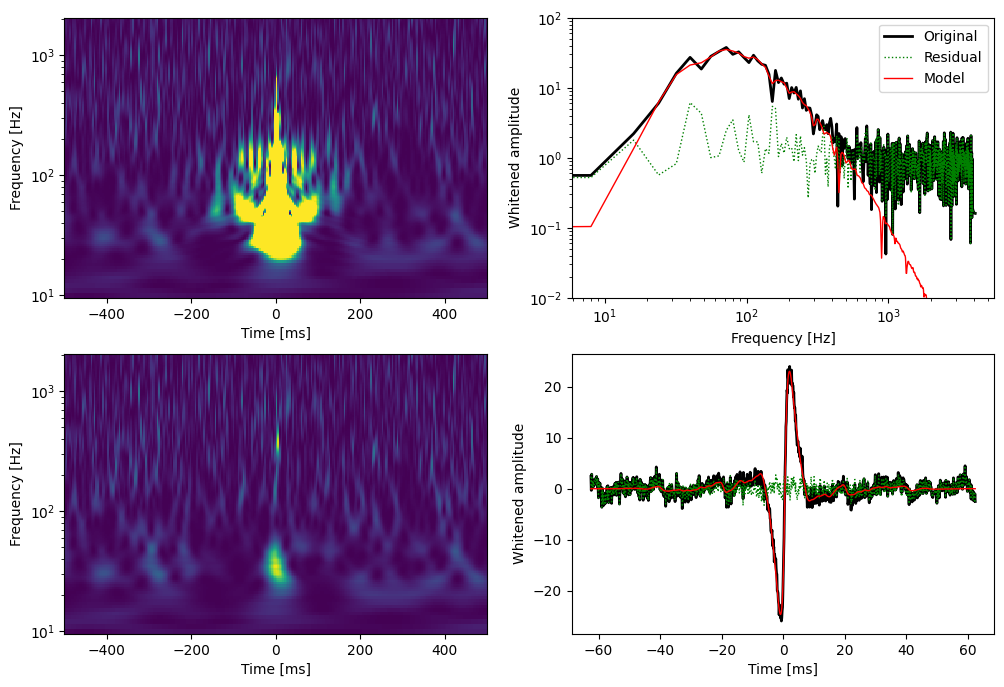

In [109]:
plot_qscan('V1', 'koi', 20)